In [1]:
# dependencies for file reading
import json
import sys
import itertools
import numpy as np
import os
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Audio, display

import librosa # conda install -c conda-forge librosa
import seaborn as sns

# managing parameters
from parammanager import paramManager
#from Tf_record import tfrecordManager

#synthesizer
import pop_sound

# Create some data sets from pop texture synth
I'd love to create TFDS sets (https://www.tensorflow.org/datasets/add_dataset#define_the_dataset_outside_tfds) but for now, they wll just be PSoundSets using paramManager


In [2]:
#initialize data and parameter structures
paramArr = []
data = []

## Loading configuration file

In [3]:
# load config file
config_file = './config_file.json' # give full path if needed
with open(config_file) as json_file:
	data = json.load(json_file)
	print("Reading parameters for generating ", data['soundname'], " texture.. ")
	for p in data['params']:
	
	    print('ParamName: ' + p['pname'])
	    print('Units    : ' + p['units']) 
	    print("Formula  : " + p['formula'])
	    p['formula'] = eval("lambda *args: " + p['formula'])
	    print('')
	    paramArr.append(p)

Reading parameters for generating  pop_sound  texture.. 
ParamName: rate
Units    : rate = 2*exp
Formula  : 2**args[0]

ParamName: irreg
Units    : sd = irregularity/events per second
Formula  : .04*10**args[0]/args[1]

ParamName: cf
Units    : Frequency
Formula  : 440**args[0]



In [4]:
# read samplerate
sr = data['samplerate']

## ------------------ Visualization section ----------------------------------------
(not required for dataset generation)

### Global variables

In [5]:
sr=16000 # sampling rate

### Sound shape

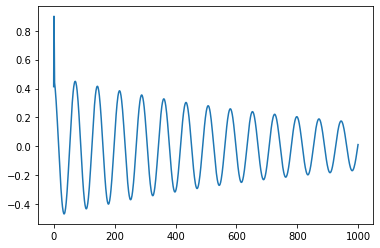

In [6]:
'''
General description of soundModel 
@numSamples - total number of samples to generate (should be enough to include the ringing of the filter)
@f0 - bandpass filter center frequency
@Q - bandpass filter Q value (<1 creates a long ringing tone at f0, >10 is shorter ringining wide-band noise)
@sr - sample rate
'''

numSamples = 1000
f0 = 220 #cf
Q = 40 # pitch bend

foo=pop_sound.soundModel(f0, Q, sr, 1000)
plt.plot(foo)

# Hearing this sound
display(Audio(foo, rate=16000, autoplay=True))

### Visualize distribution of events 
(note that for small sd, the is a large effect of number of bins)

### Generate event locations

In [7]:
#generate events for N seconds and show them with a delta where they will occur
rate = 1.0
irregularity = 0.4
cf = 440
soundSecs = 4

## derived parameters
eventsPerSecond=4*int(rate)
sd = irregularity/eventsPerSecond
numSamples=soundSecs*sr

print("Events per second", eventsPerSecond)
print("Irregularity", sd)
print("Number of samples", numSamples)

Events per second 4
Irregularity 0.1
Number of samples 64000


Generating 16 events with irregularity of  0.1  for  4  seconds


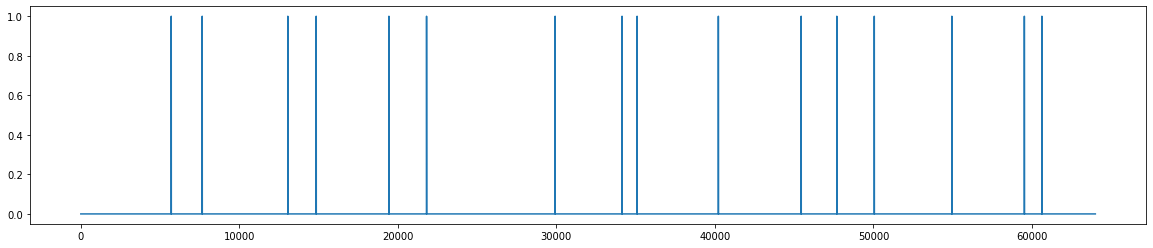

In [8]:
# visualization to undersstand how parametric variation will change the event generation process
print("Generating {} events with irregularity of ".format(eventsPerSecond*soundSecs),sd, " for ", soundSecs, " seconds")
sig = pop_sound.generateEvents(eventsPerSecond, sd, soundSecs, numSamples, sr)
len(sig)

plt.figure(figsize=(20,4))
plt.plot(sig)
# x-axis: sample value

### Now create the signal by adding in filtered pops

In [11]:
'''
   Take a list of event times, and return our signal of filtered pops at those times
'''
myevents= pop_sound.generateRandom(eventsPerSecond, sd, soundSecs, numSamples, sr) 
sig = pop_sound.elist2signal(myevents, soundSecs, sr, cf, Q)
#
print("Generated textures with fundamental of ", cf, " Hertz with frequency of deviation ", Q, " hertz ")

Generated textures with fundamental of  440  Hertz with frequency of deviation  40  hertz 


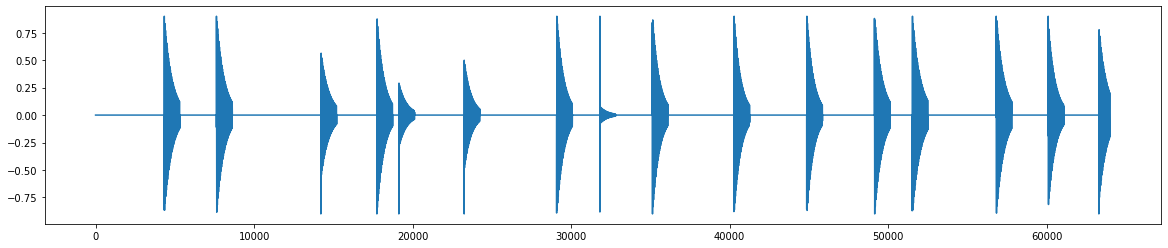

In [12]:
plt.figure(figsize=(20,4))
plt.plot(sig)
display(Audio(sig, rate=16000, autoplay=True))

## To add:
### Librosa functions for analysing wav files
### TFrecord integration

## Generating datasets

In [13]:
# if directory exists, then ok, or else create a new directory for placing generated files
filepath = os.path.dirname(os.path.realpath(data['soundname']))
outPath = os.path.join(filepath, data['soundname'])
if not os.path.isdir(outPath):
    os.mkdir(outPath)

print("Output files printed at ", outPath)

Output files printed at  /Users/alex/Desktop/RNN-project/gitRepos/popTextureDS/pop_sound


##### for every combination of parameters
        for every variation 
            Create wav files
            Create param/Tfrecord files 

In [14]:
cartParam = []
# one way to generate parameter combinations
for p in paramArr:
    cartParam.append(np.linspace(p["minval"], p["maxval"], p["nvals"], endpoint=True))
    
enumParam = list(itertools.product(*cartParam))

print("Combination of parameters")
for e in enumParam:
    print(e)

Combination of parameters
(0.0, 0.0, 0.0)
(0.0, 0.0, 1.0)
(0.0, 1.0, 0.0)
(0.0, 1.0, 1.0)
(4.0, 0.0, 0.0)
(4.0, 0.0, 1.0)
(4.0, 1.0, 0.0)
(4.0, 1.0, 1.0)


In [15]:
for enumP in enumParam: # caretesian product of lists
	fname = '/' + data['soundname']

	'''Construct filenames with static parameters'''
	for paramNum in range(len(paramArr)):
		fname = fname + '--' + paramArr[paramNum]['pname'] + '-'+'{:05.2f}'.format(enumP[paramNum])

	vFilesWav = []
	vFilesParam = []	

	''' Construct variations filenames'''
	for v in range(data['numVariations']):
		vFilesWav.append(fname + '--v-'+'{:03}'.format(v)+'.wav') 
		vFilesParam.append(fname + '--v-'+'{:03}'.format(v)+'.params') 

	''' Synthesize wav files'''
	varDurationSecs=data["soundDuration"]/data["numVariations"]  #No need to florring this?
	sig = pop_sound.generate_events(enumP, sr, data["soundDuration"])

	''' Create param files '''
	for v in range(data['numVariations']):
		pop_sound.synthesize(sig, vFilesWav[v], outPath, sr, v, varDurationSecs)
		pm=paramManager.paramManager(vFilesParam[v], outPath)
		pm.initParamFiles(overwrite=True)
		for pnum in range(len(paramArr)):
			pm.addParam(vFilesParam[v], paramArr[pnum]['pname'], [0,data['soundDuration']], [enumP[pnum], enumP[pnum]], units=paramArr[pnum]['units'], nvals=paramArr[pnum]['nvals'], minval=paramArr[pnum]['minval'], maxval=paramArr[pnum]['maxval'])

		#tfm=tfrecordManager.tfrecordManager(vFilesParam[v], outPath)
		#data,sr = librosa.core.load(outPath + fname + '--v-'+'{:03}'.format(v)+'.wav',sr=16000)
		#print(len(data))
		#tfm.addFeature(vFilesParam[v], 'audio', [0,len(data)], data, units='samples', nvals=len(data), minval=0, maxval=0)
		#for pnum in range(len(paramArr)):
		#	print(pnum)
		#	tfm.addFeature(vFilesParam[v], paramArr[pnum]['pname'], [0,data['soundDuration']], [enumP[pnum], enumP[pnum]], units=paramArr[pnum]['units'], nvals=paramArr[pnum]['nvals'], minval=paramArr[pnum]['minval'], maxval=paramArr[pnum]['maxval'])
		#tfm.writeRecordstoFile()

Printing /pop_sound--rate-00.00--irreg-00.00--cf-00.00--v-000.wav
pop_sound--rate-00.00--irreg-00.00--cf-00.00--v-000.params 
Printing /pop_sound--rate-00.00--irreg-00.00--cf-00.00--v-001.wav
pop_sound--rate-00.00--irreg-00.00--cf-00.00--v-001.params 
Printing /pop_sound--rate-00.00--irreg-00.00--cf-01.00--v-000.wav
pop_sound--rate-00.00--irreg-00.00--cf-01.00--v-000.params 
Printing /pop_sound--rate-00.00--irreg-00.00--cf-01.00--v-001.wav
pop_sound--rate-00.00--irreg-00.00--cf-01.00--v-001.params 
Printing /pop_sound--rate-00.00--irreg-01.00--cf-00.00--v-000.wav
pop_sound--rate-00.00--irreg-01.00--cf-00.00--v-000.params 
Printing /pop_sound--rate-00.00--irreg-01.00--cf-00.00--v-001.wav
pop_sound--rate-00.00--irreg-01.00--cf-00.00--v-001.params 
Printing /pop_sound--rate-00.00--irreg-01.00--cf-01.00--v-000.wav
pop_sound--rate-00.00--irreg-01.00--cf-01.00--v-000.params 
Printing /pop_sound--rate-00.00--irreg-01.00--cf-01.00--v-001.wav
pop_sound--rate-00.00--irreg-01.00--cf-01.00--v-001.

## Check files

### Check wav files

In [16]:
# list files
import glob

print(data['soundname'])
for f in glob.glob(data['soundname'] + "/*.wav"):
    print(os.path.relpath(f))


pop_sound
pop_sound/pop_sound--rate-04.00--irreg-00.00--cf-01.00--v-000.wav
pop_sound/pop_sound--rate-04.00--irreg-00.00--cf-01.00--v-001.wav
pop_sound/pop_sound--rate-00.00--irreg-00.00--cf-00.00--v-000.wav
pop_sound/pop_sound--rate-00.00--irreg-00.00--cf-00.00--v-001.wav
pop_sound/pop_sound--rate-04.00--irreg-01.00--cf-00.00--v-000.wav
pop_sound/pop_sound--rate-04.00--irreg-01.00--cf-00.00--v-001.wav
pop_sound/pop_sound--rate-00.00--irreg-01.00--cf-01.00--v-000.wav
pop_sound/pop_sound--rate-00.00--irreg-01.00--cf-01.00--v-001.wav
pop_sound/pop_sound--rate-00.00--irreg-01.00--cf-00.00--v-001.wav
pop_sound/pop_sound--rate-00.00--irreg-01.00--cf-00.00--v-000.wav
pop_sound/pop_sound--rate-04.00--irreg-01.00--cf-01.00--v-001.wav
pop_sound/pop_sound--rate-04.00--irreg-01.00--cf-01.00--v-000.wav
pop_sound/pop_sound--rate-00.00--irreg-00.00--cf-01.00--v-001.wav
pop_sound/pop_sound--rate-00.00--irreg-00.00--cf-01.00--v-000.wav
pop_sound/pop_sound--rate-04.00--irreg-00.00--cf-00.00--v-001.wav


In [17]:
# select and play

# replace the filename you want as string here
filepath = 'pop_sound/pop_sound--rate-04.00--irreg-00.00--cf-00.00--v-000.wav'
audio,sr = librosa.core.load(filepath,sr=16000)
display(Audio(audio, rate=sr, autoplay=True))

### Check param files

In [18]:
# list files
import glob

for f in glob.glob(data['soundname'] + "/*.params"):
    print(os.path.relpath(f))


pop_sound/pop_sound--rate-00.00--irreg-00.00--cf-00.00--v-000.params
pop_sound/pop_sound--rate-04.00--irreg-01.00--cf-00.00--v-000.params
pop_sound/pop_sound--rate-00.00--irreg-01.00--cf-01.00--v-000.params
pop_sound/pop_sound--rate-04.00--irreg-00.00--cf-01.00--v-000.params
pop_sound/pop_sound--rate-00.00--irreg-00.00--cf-01.00--v-000.params
pop_sound/pop_sound--rate-04.00--irreg-01.00--cf-01.00--v-000.params
pop_sound/pop_sound--rate-00.00--irreg-01.00--cf-00.00--v-000.params
pop_sound/pop_sound--rate-04.00--irreg-00.00--cf-00.00--v-000.params
pop_sound/pop_sound--rate-04.00--irreg-01.00--cf-00.00--v-001.params
pop_sound/pop_sound--rate-00.00--irreg-00.00--cf-00.00--v-001.params
pop_sound/pop_sound--rate-04.00--irreg-00.00--cf-01.00--v-001.params
pop_sound/pop_sound--rate-00.00--irreg-01.00--cf-01.00--v-001.params
pop_sound/pop_sound--rate-04.00--irreg-01.00--cf-01.00--v-001.params
pop_sound/pop_sound--rate-00.00--irreg-00.00--cf-01.00--v-001.params
pop_sound/pop_sound--rate-04.00--i

In [19]:
# select and play

filepath = 'pop_sound/pop_sound--rate-04.00--irreg-00.00--cf-00.00--v-000.params'
# replace the filename you want as string here
f = open( filepath,'r')
print(f.read())


{
    "meta": {
        "filename": "pop_sound--rate-04.00--irreg-00.00--cf-00.00--v-000.params"
    },
    "rate": {
        "times": [
            0,
            4
        ],
        "values": [
            4.0,
            4.0
        ],
        "units": "rate = 2*exp",
        "nvals": 2,
        "minval": 0,
        "maxval": 4,
        "origMinval": null,
        "origUnits": null,
        "origMaxval": null
    },
    "irreg": {
        "times": [
            0,
            4
        ],
        "values": [
            0.0,
            0.0
        ],
        "units": "sd = irregularity/events per second",
        "nvals": 2,
        "minval": 0,
        "maxval": 1,
        "origMinval": null,
        "origUnits": null,
        "origMaxval": null
    },
    "cf": {
        "times": [
            0,
            4
        ],
        "values": [
            0.0,
            0.0
        ],
        "units": "Frequency",
        "nvals": 2,
        "minval": 0,
        "maxval": 1,
   